# Lab 2 : Visibility Graphs
---

# Import Dependencies

In [66]:
from matplotlib import pyplot as plt
from matplotlib import path
import numpy as np
import sys
import csv
import math

## Point Class

In [67]:
class Point:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y
    
    def dist(self, p):
        # Distance between point self and point p
        return math.sqrt((self.x - p.x)**2 + (self.y - p.y)**2)
    
    def numpy(self):
        # return the point (x, y) as a numpy array
        return np.array([self.x, self.y])
        
    def dist_line(self, l):
        # return the distance between point self an line l of type Segment.
        return np.linalg.norm(np.cross(l.p2.numpy() - l.p1.numpy(), l.p1.numpy() - self.numpy())) / np.linalg.norm(l.p2.numpy() - l.p1.numpy())

    def __str__(self):
        # returns point self as a string
        return "({}, {})".format(np.round(self.x, 2), np.round(self.y, 2))

    def dot(self, p):
        # Dot product
        return self.x * p.x + self.y*p.y

    def length(self):
        # returns modulus of point self
        return math.sqrt(self.x**2 + self.y**2)

    def vector(self, p):
        # creates a vector of type Point between point self and point p
        return Point(p.x - self.x, p.y - self.y)

    def unit(self):
        # makes the point self unitary if possible
        mag = self.length()
        if mag > 0:
            return Point(self.x/mag, self.y/mag)
        else:
            return Point(0, 0)

    def scale(self, sc):
        # multiplies point self by scalar sc
        return Point(self.x * sc, self.y * sc)

    def __add__(self, p):
        # add point self and point p component by component
        return Point(self.x + p.x, self.y + p.y)

    def __sub__(self, p):
        # substracts point self and point p component by component
        return Point(self.x - p.x, self.y - p.y)

    def __truediv__(self, s):
        # divides point self by scalar s
        return Point(self.x / s, self.y / s)
    
    def __floordiv__(self, s):
        # integer division of point self by scalar s
        return Point(int(self.x / s), int(self.y / s))
    
    def __mul__(self, s):
        return Point(self.x * s, self.y * s)
    
    def __rmul__(self, s):
        return self.__mul__(s)
    
    def __eq__(self, __o: object) -> bool:
        if abs(self.x - __o.x) < 0.0001 and abs(self.y - __o.y) < 0.0001:
            return True
        return False 

    def ccw(self, A, B, C):
        return (C.y - A.y) * (B.x - A.x) >= (B.y - A.y) * (C.x - A.x)

    def det(self, a, b):
        return a[0] * b[1] - a[1] * b[0]



# Segment Class

In [68]:
class Segment:
    def __init__(self, p1=Point(), p2=Point()):
        # A segment is defined by two Point objects
        self.p1 = p1
        self.p2 = p2

    @classmethod
    def point_angle_length(cls, p1=Point(), angle=0, length=1):
        # A segment can be initialized with a Point object, an angle, and a segment length.
        x2 = p1.x + math.cos(angle) * length
        y2 = p1.y + math.sin(angle) * length
        return cls(p1, Point(x2, y2))
        
    def intersect(self, s):
        # Return true if Segment self and Segment s intersect
        if self.ccw(self.p1, s.p1, s.p2) != self.ccw(self.p2, s.p1, s.p2) and self.ccw(self.p1, self.p2, s.p1) != self.ccw(self.p1, self.p2, s.p2):
            p = self.intersection_point(s)
            if p == self.p1 or p == self.p2:
                return False, None
            else:
                return True, p
        else:
            return False, None

    def intersection_point(self, line):
        # Returns the point in which line Segment self and line Segment s intersect
        xdiff = (self.p1.x - self.p2.x, line.p1.x - line.p2.x)
        ydiff = (self.p1.y - self.p2.y, line.p1.y - line.p2.y)

        div = self.det(xdiff, ydiff)
        if div == 0:
            print("Something went wrong!")
            return None

        d = (self.det((self.p1.x, self.p1.y), (self.p2.x, self.p2.y)), self.det((line.p1.x, line.p1.y), (line.p2.x, line.p2.y)))
        x = self.det(d, xdiff) / div
        y = self.det(d, ydiff) / div
        return Point(x, y)
    
    def __str__(self):
        return "[{}, {}]".format(self.p1, self.p2)
    
    def ccw(self,A, B, C):
        return (C.y - A.y) * (B.x - A.x) >= (B.y - A.y) * (C.x - A.x)

    def det(self,a, b):
        return a[0] * b[1] - a[1] * b[0]


# RPS Class

In [69]:
class RotationalPlaneSweep:
    def __init__(self) -> None:
        pass

    def rotational_plane_sweep(self, vertexs, goal):
        for vertex in vertexs[0:-1]: # Iterate through every vertex except goal
            w = Segment(vertex, Point(goal.x, vertex.y))# define w line
            sorted_vetex  =  [] # sorted vertex according to alpha 
            for v in vertexs: # calculate alpha for each vertex 
                
            alpha_list = []
            s_list  = []
        return output_connection

# Brute Force Class

In [70]:
class BruteForce:
    def __init__(self) -> None:
        pass

# Main Code 
---

## Prepare data

- load environment from csv file

In [71]:

with open("./data/env_0.csv", 'r') as file:
    csvreader = csv.reader(file)
    raw_data = []
    for row in csvreader:
        raw_data.append(row)
    raw_data.pop(0)
    vertexs = []
    edges = []
    polygons = []
    current_polygon_idx = 0
    polygon_edge_count = 0
    
    for i in range(len(raw_data)):
        print(raw_data[i])
        polygon_idx = float(raw_data[i][0])
        vx,vy = float(raw_data[i][1]), float(raw_data[i][2])
        vertexs.append(Point(vx, vy))
        if i == 0:     # For start point
            start = Point(vx, vy)
            
        elif polygon_idx == current_polygon_idx: # 
            edges.append(Segment(vertexs[i-1], vertexs[i]))
            polygon_edge_count = polygon_edge_count + 1
        elif polygon_edge_count != 0: # For first vertex of new polygon
            edges.append(Segment(vertexs[i-1-polygon_edge_count], vertexs[i-1]))
            current_polygon_idx = polygon_idx 
            polygon_edge_count  = 0
        else:
            current_polygon_idx = polygon_idx
            polygon_edge_count  = 0


    print(edges)           

['0', ' 0.6', ' 8']
['1', ' 3', ' 8.2']
['1', ' 4', ' 6.3']
['1', ' 2', ' 5.4']
['2', ' 10.3', ' 1.5']
[<__main__.Segment object at 0x7f560be18d30>, <__main__.Segment object at 0x7f560dfe2af0>, <__main__.Segment object at 0x7f560bf51340>]


- visualize environment

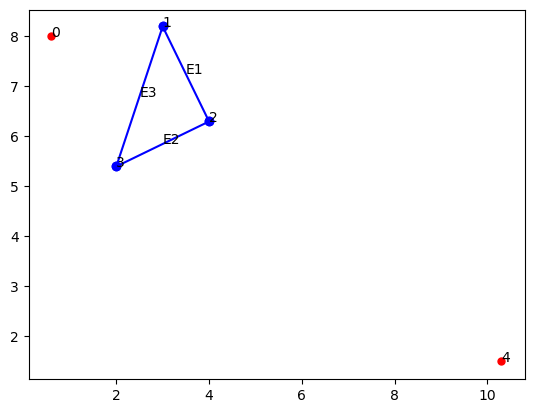

In [72]:
def plot_env(vertexs, edges): 
    i = 0
    for vertex in vertexs:
        plt.scatter(vertex.x, vertex.y, s=100, c='red', marker='.')
        plt.annotate(str(i), (vertex.x, vertex.y))
        i = i+1
    i =1
    for edge in edges:
        plt.plot([edge.p1.x , edge.p2.x], [edge.p1.y ,edge.p2.y], 'bo', linestyle="-")
        plt.annotate("E"+str(i), ((edge.p1.x+edge.p2.x)/2, (edge.p1.y+edge.p2.y)/2))
        i = i +1

plot_env(vertexs,edges)